In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import numpy as np
import control as ctl

# EXTRAINDO OS DADOS

In [78]:
df = pd.read_csv('DataBase.csv')
df = df[['time', 'theta', 'distance']]
df

,time,theta,distance
0,0.00,100,3.69
1,0.00,100,3.67
2,0.01,100,3.69
3,0.01,100,3.69
4,0.01,100,3.67
...,...,...,...
269,4.94,100,19.72
270,4.96,100,19.72
271,4.98,100,19.72
272,5.00,100,19.74


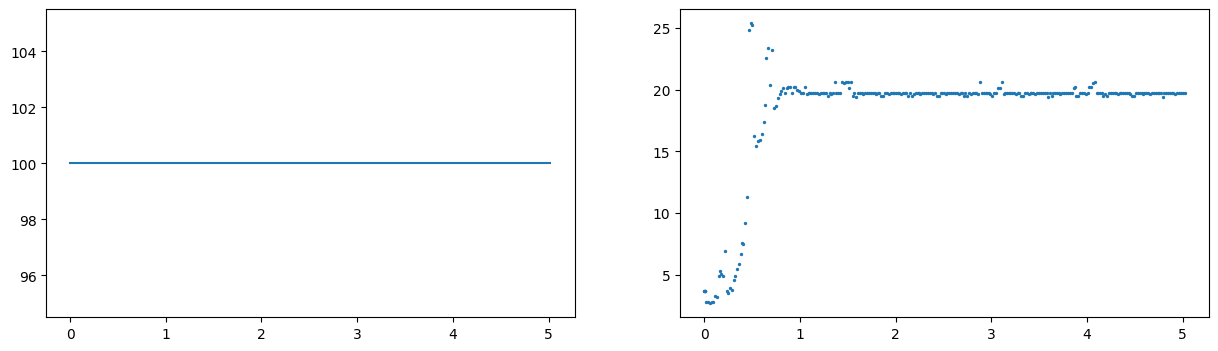

In [79]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df['time'], df['theta'])

plt.subplot(1, 2, 2)
plt.scatter(df['time'], df['distance'], s=2)

# FILTRANDO OS DADOS

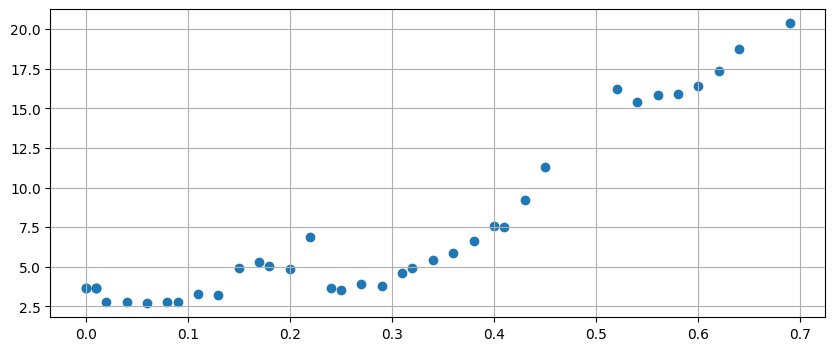

In [80]:
df = df.loc[df['distance'] < 22]
df = df.loc[df['distance'] > 2.5]
df = df.loc[df['time'] < .7]

plt.figure(figsize=(10, 4))
plt.scatter(df['time'], df['distance'])
plt.grid()
plt.show()

## FREQUÊNCIA DE AMOSTRAGEM
- Os dados precisam ter uma frequência de amostragem constante

In [81]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData = np.arange(initTime, finalTime, T)
    
    lastValue  = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


T = 0.05
df = normalizeTable(df, 'time', T)
print('size:', len(df))
df.head()

size: 15


,time,theta,distance
0,0.00,100,3.67
1,0.05,100,2.81
2,0.10,100,2.81
3,0.15,100,4.91
4,0.20,100,4.88


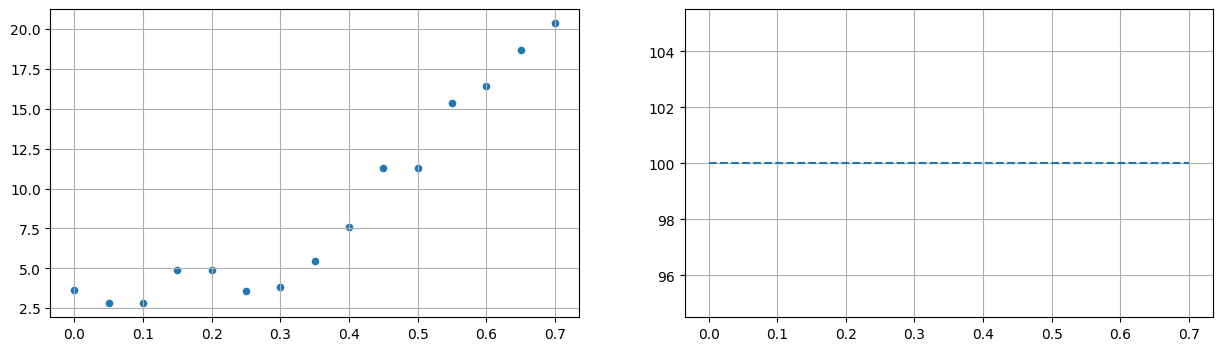

In [82]:
tData, uData, yData = df.time.values, df.theta.values, df.distance.values

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.scatter(tData, yData, s=20)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(tData, uData, '--')
plt.grid()

# DATA FITTING
O gráfico expressa a função de transferência no domínio do tempo $Y(s) = L^{-1}\{y(t)\}$, podemos encontrar $y(t)$ usando data fitting, encontrando uma função própria que se encaixe nos dados

In [83]:
def g(u, a, b, c):
    s = ctl.TransferFunction.s
    G = a/(s**2 + b*s + c)
    return ctl.forced_response(G, T=tData, U=uData)[1]

def getFunction(xDados, yDados):
    coeficientes = curve_fit(g, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

In [84]:
coefs = getFunction(uData, yData)  
coefs

[97123.03665159209, 684974.7225944331, -1324231.6480017665]

In [85]:
s = ctl.TransferFunction.s
a, b, c = coefs

G = a/(s**2 + b*s + c)
G

TransferFunction(array([97123.03665159]), array([ 1.00000000e+00,  6.84974723e+05, -1.32423165e+06]))

### CONFERINDO COM A DATABASE

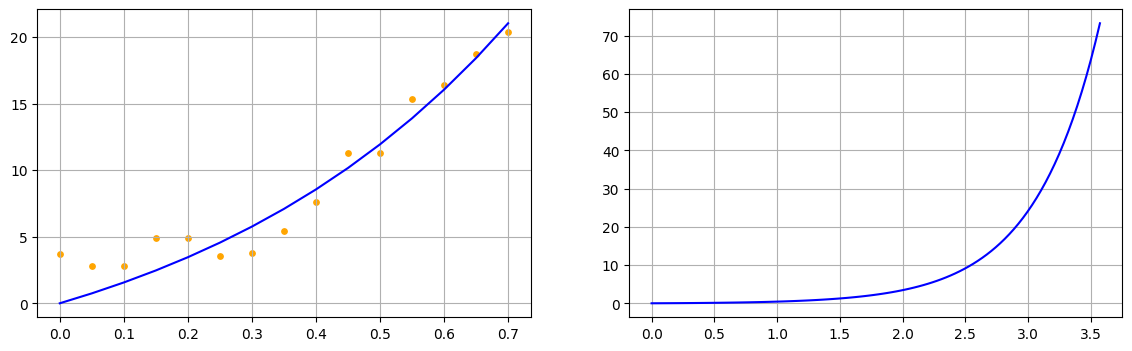

In [86]:
time, response = ctl.forced_response(G, T=tData, U=uData)
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response, color='blue')
plt.scatter(tData, yData, color='orange', s=15)
plt.grid()

plt.subplot(1, 2, 2)
time, response = ctl.step_response(G)
plt.plot(time, response, color='blue')
plt.grid()

In [ ]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})


print(sympyFunction(G))
G